In [147]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow import data as tf_data

In [107]:
num_skipped = 0
for folder_name in ("Bean", "Bitter_Gourd", "Bottle_Gourd"):
    folder_path = os.path.join("Images", folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = b"JFIF" in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            os.remove(fpath)

print(f"Deleted {num_skipped} images.")

Deleted 614 images.


In [129]:
image_size = (70, 70)
batch_size = 16

train_ds, val_ds = tf.keras.utils.image_dataset_from_directory( 
    r"D:\Images",
    validation_split=0.2,
    subset="both",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 3586 files belonging to 3 classes.
Using 2869 files for training.
Using 717 files for validation.


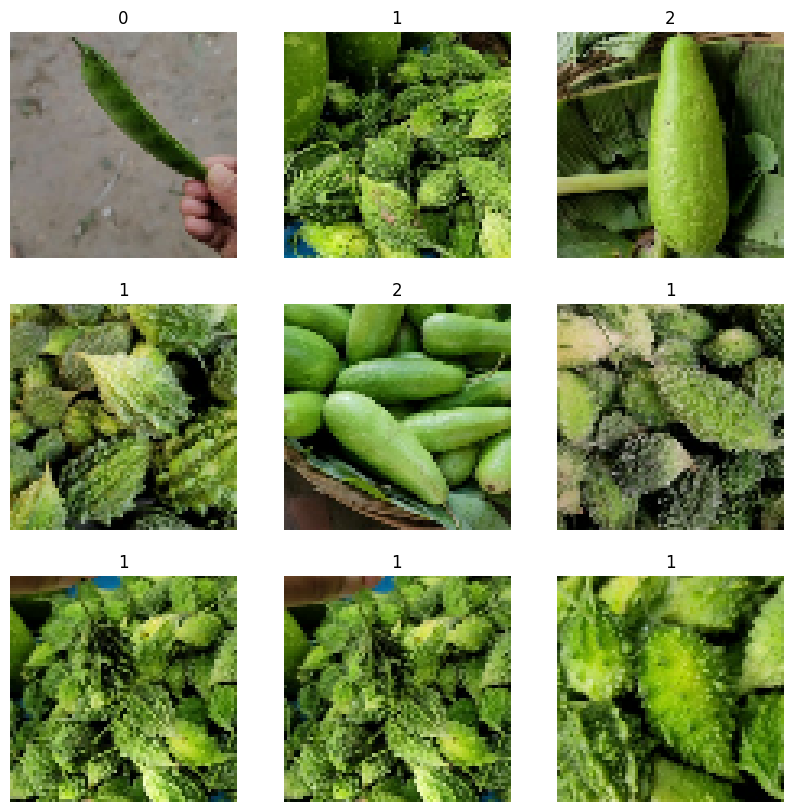

In [130]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.array(images[i]).astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

In [131]:
data_augmentation_layers = [
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1)
]


def data_augmentation(images):
    for layer in data_augmentation_layers:
        images = layer(images)
    return images

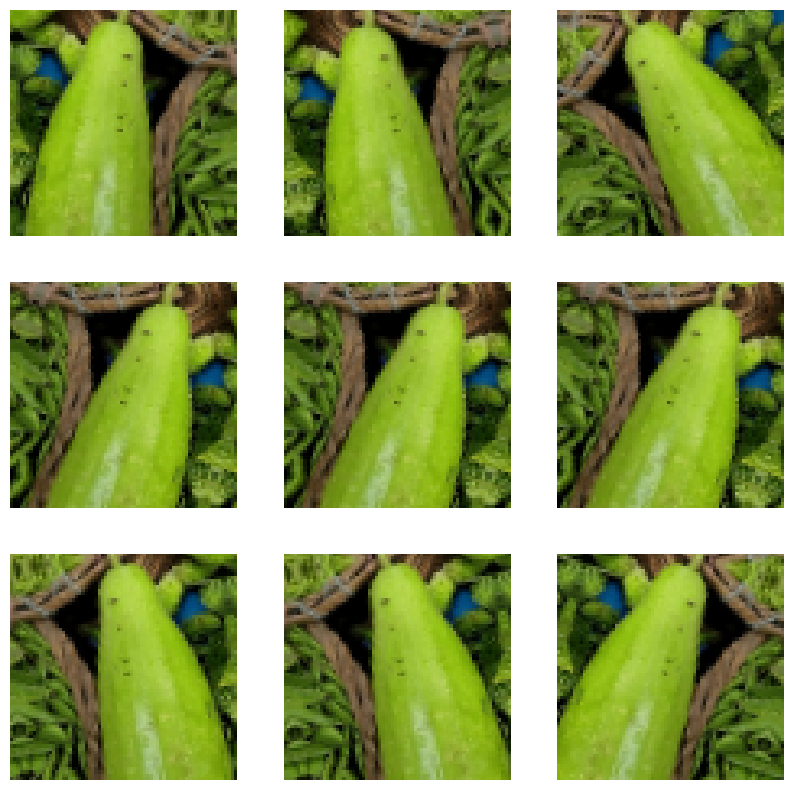

In [132]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.array(augmented_images[0]).astype("uint8"))
        plt.axis("off")

In [133]:
train_ds = train_ds.map(
    lambda img, label: (data_augmentation(img), tf.one_hot(label, 3)),
    num_parallel_calls=tf_data.AUTOTUNE,
)
val_ds = val_ds.map(
    lambda img, label: (img, tf.one_hot(label, 3)),
    num_parallel_calls=tf_data.AUTOTUNE,
)
train_ds = train_ds.prefetch(tf_data.AUTOTUNE)
val_ds = val_ds.prefetch(tf_data.AUTOTUNE)

In [134]:
model =  tf.keras.Sequential([
    tf.keras.layers.Input(shape=image_size + (3,)),
    tf.keras.layers.Conv2D(16, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(3, activation='softmax')
])


In [135]:
epochs = 25

model.compile(
    optimizer=keras.optimizers.Adam(3e-4), 
    loss="categorical_crossentropy", 
    metrics=["accuracy"]
    )
history = model.fit(
    train_ds,
    epochs=epochs,
    validation_data=val_ds
)

Epoch 1/25
180/180 ━━━━━━━━━━━━━━━━━━━━ 21s 89ms/step - accuracy: 0.4037 - loss: 13.2586 - val_accuracy: 0.5635 - val_loss: 1.0011
Epoch 2/25
180/180 ━━━━━━━━━━━━━━━━━━━━ 16s 90ms/step - accuracy: 0.5234 - loss: 1.0389 - val_accuracy: 0.6318 - val_loss: 0.9053
Epoch 3/25
180/180 ━━━━━━━━━━━━━━━━━━━━ 20s 88ms/step - accuracy: 0.6234 - loss: 0.9572 - val_accuracy: 0.6904 - val_loss: 0.8223
Epoch 4/25
180/180 ━━━━━━━━━━━━━━━━━━━━ 21s 88ms/step - accuracy: 0.6670 - loss: 0.8763 - val_accuracy: 0.7238 - val_loss: 0.7303
Epoch 5/25
180/180 ━━━━━━━━━━━━━━━━━━━━ 16s 86ms/step - accuracy: 0.6957 - loss: 0.8044 - val_accuracy: 0.7713 - val_loss: 0.7023
Epoch 6/25
180/180 ━━━━━━━━━━━━━━━━━━━━ 16s 88ms/step - accuracy: 0.6921 - loss: 0.7890 - val_accuracy: 0.7238 - val_loss: 0.6875
Epoch 7/25
180/180 ━━━━━━━━━━━━━━━━━━━━ 16s 89ms/step - accuracy: 0.7041 - loss: 0.7664 - val_accuracy: 0.8103 - val_loss: 0.6601
Epoch 8/25
180/180 ━━━━━━━━━━━━━━━━━━━━ 16s 90ms/step - accuracy: 0.7046 - loss: 0.7508 -

In [136]:
print(model.summary())

Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_50 (Conv2D)              │ (None, 68, 68, 16)     │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_51 (Conv2D)              │ (None, 66, 66, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_38 (MaxPooling2D) │ (None, 33, 33, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_26 (Dropout)            │ (None, 33, 33, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_12 (Flatten)            │ (None, 34848)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 64)             │     2,230,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_27 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,706,859 (25.58 MB)

 Trainable params: 2,235,619 (8.53 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 4,471,240 (17.06 MB)

None


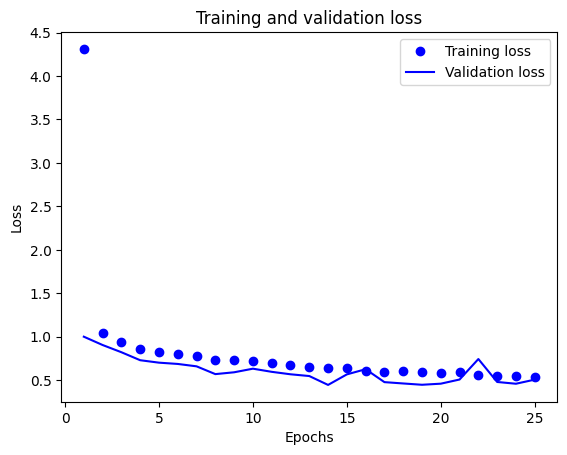

In [137]:
history_dict = history.history
loss_values = history_dict["loss"]
val_loss_values = history_dict["val_loss"]
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, "bo", label="Training loss")
plt.plot(epochs, val_loss_values, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

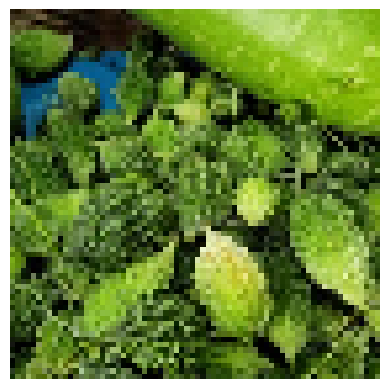

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
Bean: 21.19%
Bitter_Gourd: 57.61%
Bottle_Gourd: 21.19%
This image most likely belongs to class: Bitter_Gourd


In [140]:
img = keras.utils.load_img("Images/Bitter_Gourd/0018.jpg", target_size=image_size)
plt.imshow(img)
plt.axis("off")
plt.show()
img_array = keras.utils.img_to_array(img)
img_array = keras.ops.expand_dims(img_array, 0)

predictions = model.predict(img_array)

class_probabilities = keras.ops.softmax(predictions[0])

class_names = ["Bean", "Bitter_Gourd", "Bottle_Gourd"] 
for i, class_name in enumerate(class_names):
    print(f"{class_name}: {100 * float(class_probabilities[i]):.2f}%")

predicted_class = class_names[keras.ops.argmax(class_probabilities)]
print(f"This image most likely belongs to class: {predicted_class}")

In [142]:
from tensorflow.keras.applications import EfficientNetB0

def build_model(num_classes):
    inputs = layers.Input(shape=image_size + (3,))
    model = EfficientNetB0(include_top=False, input_tensor=inputs, weights="imagenet")

    model.trainable = False

    x = layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
    x = layers.BatchNormalization()(x)

    top_dropout_rate = 0.2
    x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)
    outputs = layers.Dense(num_classes, activation="softmax", name="pred")(x)

    model = keras.Model(inputs, outputs, name="EfficientNet")
    optimizer = keras.optimizers.Adam(learning_rate=1e-2)
    model.compile(
        optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
    )
    return model

In [143]:
model = build_model(num_classes=3)

epochs = 25  
hist = model.fit(train_ds,epochs=epochs, validation_data=val_ds)

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Epoch 1/25
180/180 ━━━━━━━━━━━━━━━━━━━━ 49s 178ms/step - accuracy: 0.9284 - loss: 0.2442 - val_accuracy: 0.9930 - val_loss: 0.0472
Epoch 2/25
180/180 ━━━━━━━━━━━━━━━━━━━━ 34s 140ms/step - accuracy: 0.9639 - loss: 0.1967 - val_accuracy: 0.9874 - val_loss: 0.1760
Epoch 3/25
180/180 ━━━━━━━━━━━━━━━━━━━━ 25s 139ms/step - accuracy: 0.9769 - loss: 0.1474 - val_accuracy: 0.9958 - val_loss: 0.0392
Epoch 4/25
180/180 ━━━━━━━━━━━━━━━━━━━━ 26s 143ms/step - accuracy: 0.9798 - loss: 0.2152 - val_accuracy: 0.9958 - val_loss: 0.0296
Epoch 5/25
180/180 ━━━━━━━━━━━━━━━━━━━━ 30s 166ms/step - accuracy: 0.9824 - loss: 0.1608 - val_accuracy: 0.9986 - val_loss: 0.0033
Epoch 6/25
180/180 ━━━━━━━━━━━━━━━━━━━━ 37s 144ms/step - accuracy: 0.9865 - loss: 0.1683 - val_accuracy: 0.9986 - val_loss: 0.0015
Epoch 7/25
180/180 ━━━━━━━━━━━━━━━━━━━━ 25s 139ms/step - accuracy: 0.9877 - loss: 0.1497 - val_accuracy: 0.9958 - val_loss: 0.0276
Epoch 8/25
180/180 ━━━━━━━━━━━━━

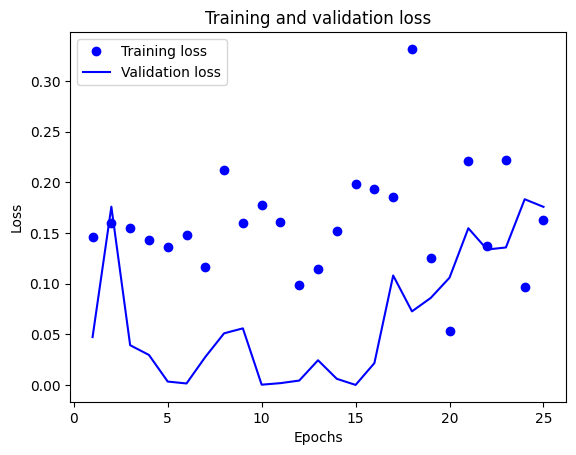

In [144]:
history_dict = hist.history
loss_values = history_dict["loss"]
val_loss_values = history_dict["val_loss"]
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, "bo", label="Training loss")
plt.plot(epochs, val_loss_values, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [145]:
def unfreeze_model(model):
    for layer in model.layers[-20:]:
        if not isinstance(layer, layers.BatchNormalization):
            layer.trainable = True

    optimizer = keras.optimizers.Adam(learning_rate=1e-5)
    model.compile(
        optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
    )


unfreeze_model(model)

epochs = 4  
hist = model.fit(train_ds,epochs=epochs, validation_data=val_ds)

Epoch 1/4
180/180 ━━━━━━━━━━━━━━━━━━━━ 61s 213ms/step - accuracy: 0.9917 - loss: 0.1670 - val_accuracy: 0.9972 - val_loss: 0.1301
Epoch 2/4
180/180 ━━━━━━━━━━━━━━━━━━━━ 30s 168ms/step - accuracy: 0.9928 - loss: 0.1369 - val_accuracy: 0.9972 - val_loss: 0.1131
Epoch 3/4
180/180 ━━━━━━━━━━━━━━━━━━━━ 30s 168ms/step - accuracy: 0.9944 - loss: 0.0727 - val_accuracy: 0.9972 - val_loss: 0.1020
Epoch 4/4
180/180 ━━━━━━━━━━━━━━━━━━━━ 34s 190ms/step - accuracy: 0.9922 - loss: 0.1405 - val_accuracy: 0.9986 - val_loss: 0.1036


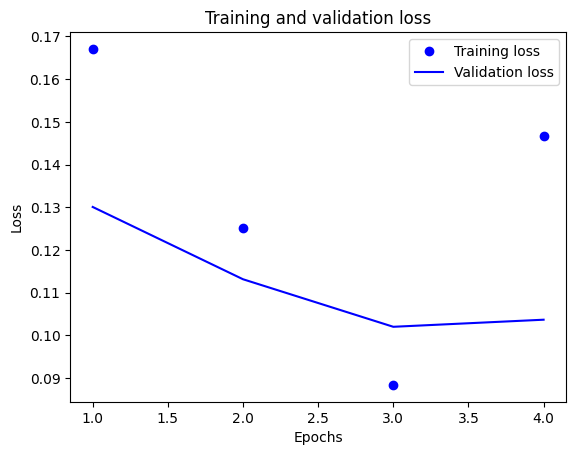

In [146]:
history_dict = hist.history
loss_values = history_dict["loss"]
val_loss_values = history_dict["val_loss"]
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, "bo", label="Training loss")
plt.plot(epochs, val_loss_values, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()